In [1]:
import numpy as np
import pandas as pd
import pymysql
import datetime
import matplotlib.pyplot as plt
import seaborn as sns
import sys
import requests
import itertools
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Lasso
from sklearn.linear_model import LassoCV
from sklearn.linear_model import LogisticRegression
%matplotlib inline

In [2]:
conn = pymysql.connect(host='localhost', user='root', password='Sk1ttles', db='nba_stats_prod', autocommit=True)

In [614]:
train = """

select basic.player_id,
       box_view.team,
       box_view.game_hash,
       box_view.game_date,
       basic.pts,
       basic.minutes_played,
       basic.fga,
       basic.3pa,
       basic.orb,
       basic.trb,
       basic.ast,
       basic.stl,
       basic.blk,
       basic.tov,
       basic.pf,
       adv.turnover_pct,
       adv.usage_pct,
       a_stats.pace,
       a_stats.pie,
       adv.offensive_rating,
       adv.defensive_rating,
       p_score.pct_2pt_fga,
       p_score.pct_3pt_fga,
       p_score.pct_pts_fbps,
       p_score.pct_pts_ft,
       p_score.pct_pts_off_to,
       p_usg.pct_fga,
       p_usg.pct_3pa,
       p_usg.pct_fta,
       p_usg.pct_stl,
       reg_avg.fg_a as tot_fg_a,
       reg_avg.3p_a as tot_3p_a,
       reg_avg.ft_a as tot_ft_a,
       reg_avg.reb as tot_reb,
       reg_avg.ast as tot_ast,
       reg_avg.blk as tot_blk,
       reg_avg.stl as tot_stl,
       reg_avg.pf as tot_pf,
       reg_avg.`TO` as tot_to,
       opp_team_pts.opp_pts,
       opp_team_pts.diff,
       misc.FBPS,
       misc.second_chance_pts

from (

     select b.game_hash,
            b.home_team as team,
            b.game_date,
            team.team_id as away_id,
            lu.season
     from box_score_map as b
     inner join game_date_lookup as lu on b.game_date = lu.day
     inner join team_info as team on b.away_team = team.team
     where b.game_date < current_date and
           lu.season > 2008

     ) as box_view

inner join player_team_map as play_m on ( (box_view.team = play_m.team) and (
box_view.season = play_m.season) )
inner join basic_box_stats as basic on ( (box_view.game_hash = basic.game_hash) and (
play_m.player_id = basic.player_id) )
inner join advanced_box_stats as adv on ( (box_view.game_hash = adv.game_hash) and (
play_m.player_id = adv.player_id) )
inner join player_scoring_stats as p_score on ( (box_view.game_hash = p_score.game_hash) and (
play_m.player_id = p_score.player_id) )
inner join player_usage_stats as p_usg on ( (box_view.game_hash = p_usg.game_hash) and (
play_m.player_id = p_usg.player_id) )
inner join team_advanced_boxscore_stats as a_stats on ( (box_view.game_hash = a_stats.game_hash) and (box_view.team = a_stats.team) )
left outer join RegularSeasonAverages as reg_avg on ( (basic.player_id = reg_avg.player_id) and (box_view.season -1 = reg_avg.season) )
inner join points as opp_team_pts on box_view.away_id = opp_team_pts.team_id and box_view.season -1 = opp_team_pts.season
inner join team_misc_boxscore_stats as misc on ( (box_view.game_hash = misc.game_hash) and (box_view.team = misc.team) )
order by basic.player_id,
         box_view.game_date asc;
"""

In [615]:
df = pd.read_sql(sql=train, con=conn, index_col=None)

In [616]:
def time_convert(minutes_played):
    time_list = minutes_played.split(':')
    try:
        return ((int(time_list[0]) * 60) + int(time_list[1]))
    except ValueError:
        return 0

In [617]:
def concat_drop(df, dummy_var_col, drop_list):
    for field in dummy_var_col:
        df = pd.concat([df, gen_dummby_var(df, field)], axis=1)
    df.drop(drop_list, axis=1, inplace=True)
    return df

In [618]:
def gen_dummby_var(df, column):
    return pd.get_dummies(df[column], drop_first=True)

In [619]:
#### finding number of days in between games on player level 

In [620]:
#df['game_date'] = pd.to_datetime(df['game_date'])
#df.head()

In [621]:
df.loc[:, 'minutes_played'] = df.loc[:, 'minutes_played'].apply(time_convert)

In [622]:
df['days_of_rest'] = df.game_date.diff().dt.days.fillna(0).astype(int)
df[df['days_of_rest'] < 0] = 0
#df['days_of_rest']

In [623]:
df.drop([ 'player_id', 'team', 'game_hash', 'game_date'], axis=1, inplace=True)
clean_df = df[df['minutes_played'] >= 720]
#clean_df = concat_drop(df[df['minutes_played'] >= 900], ['home_away'], [ 'player_id', 'team', 'game_hash', 'game_date'])

In [624]:
#clean_df.drop('Home', inplace=True, axis=1)
clean_df.head()
#group_df = clean_df.groupby(['game_date','team'])
#group_df.head()

,pts,minutes_played,fga,3pa,orb,trb,ast,stl,blk,tov,...,tot_ast,tot_blk,tot_stl,tot_pf,tot_to,opp_pts,diff,FBPS,second_chance_pts,days_of_rest
5,0,815,2,1,0,1,0,0,0,2,...,NaN,NaN,NaN,NaN,NaN,105.0,-3.1,25,16,2
13,2,987,5,3,0,2,1,0,0,1,...,NaN,NaN,NaN,NaN,NaN,98.4,1.6,23,12,5
16,6,1233,4,3,0,6,1,0,0,0,...,NaN,NaN,NaN,NaN,NaN,92.9,10.6,21,28,2
17,5,1484,4,3,1,4,0,0,2,1,...,NaN,NaN,NaN,NaN,NaN,95.9,1.8,19,6,2
18,5,808,6,3,3,5,2,0,0,0,...,NaN,NaN,NaN,NaN,NaN,100.2,4.3,12,22,16


In [625]:
#for group in group_df.groups:
 #   print(group)

In [626]:
clean_df = clean_df.fillna(0)

In [627]:
x = clean_df.loc[:, 'minutes_played':]
y = clean_df.loc[:, 'pts']

In [628]:
X_train, X_test, y_train, y_test = train_test_split(clean_df.loc[:, 'minutes_played':], clean_df.loc[:, 'pts'], test_size=.33)

In [629]:
lm = LinearRegression()

In [630]:
lm.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [631]:
predictions = lm.predict(X_test)

Text(0,0.5,'Predicted Y')

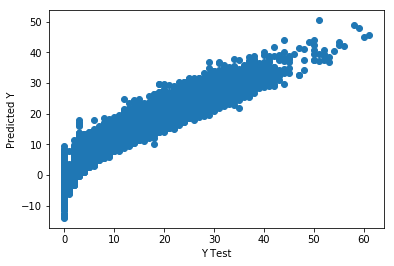

In [632]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

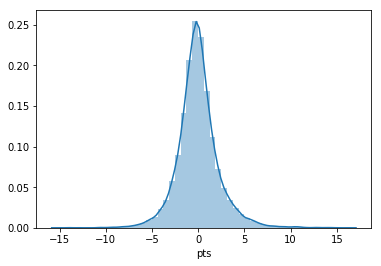

In [633]:
sns.distplot((y_test-predictions),bins=50);

In [634]:
coeffecients = pd.DataFrame(lm.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.002176
fga,0.924979
3pa,0.062746
orb,-0.452077
trb,0.064574
ast,-0.336100
stl,0.177624
blk,0.083035
tov,0.053575
pf,-0.002684


In [635]:
lm.score(X_test, y_test)

0.91404866842336208

In [25]:
### Experimenting with Lasso regression

In [26]:
lasso = Lasso(alpha=0.0023101297000831605)  #Home: 0.00174333 - 0.00221222

In [27]:
lasso.fit(X_train, y_train)

Lasso(alpha=0.0023101297000831605, copy_X=True, fit_intercept=True,
   max_iter=1000, normalize=False, positive=False, precompute=False,
   random_state=None, selection='cyclic', tol=0.0001, warm_start=False)

In [28]:
predictions = lasso.predict(X_test)

Text(0,0.5,'Predicted Y')

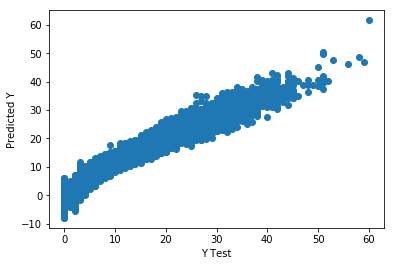

In [29]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

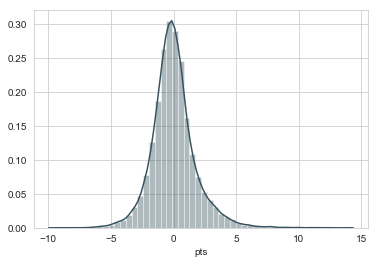

In [30]:
sns.set_palette("GnBu_d")
sns.set_style('whitegrid')
sns.distplot(y_test-predictions, bins=50)

In [31]:
lasso.score(X_test, y_test)

0.94888301125480468

In [32]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.002445
fga,0.560851
3pa,0.323101
orb,-0.344068
trb,0.011079
ast,-0.126093
stl,-0.085693
blk,0.001704
tov,-0.027425
pf,0.011039


In [510]:
#### Using Lasso cross-validation model

In [511]:
lasso_cv = LassoCV()

In [512]:
lasso_cv.fit(X_train, y_train)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False)

In [513]:
predictions_cv = lasso_cv.predict(X_test)

Text(0,0.5,'Predicted Y')

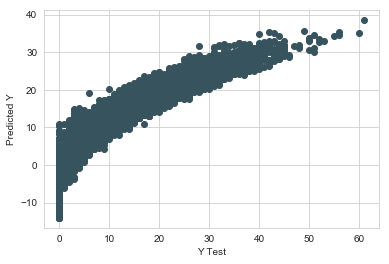

In [514]:
plt.scatter(y_test,predictions_cv)
plt.xlabel('Y Test')
plt.ylabel('Predicted Y')

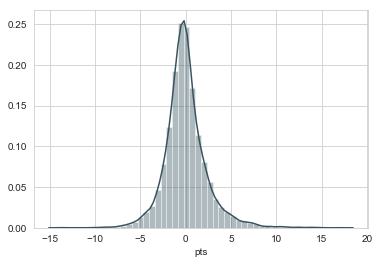

In [515]:
sns.distplot(y_test-predictions, bins=50)

In [516]:
lasso_cv.score(X_test, y_test)

0.87151947318590561

In [517]:
coeffecients = pd.DataFrame(lasso.coef_,X_test.columns)
coeffecients.columns = ['Coeffecient']
coeffecients

,Coeffecient
minutes_played,0.003458
fga,0.724111
3pa,0.056322
orb,-0.400927
trb,0.034243
ast,-0.312361
stl,0.019924
blk,0.015208
tov,0.000000
pf,-0.000000


In [518]:
### optimizing alpha value in Lasso regression

In [636]:
alphas = np.logspace(-4, -1, 50)
#alphas = np.linspace(.001, .999, 100) #0.00464159
#alphas

In [637]:
scores = np.empty_like(alphas)

In [638]:
for i, a in enumerate(alphas):
    lasso = Lasso(alpha=a)
    lasso.fit(X_train, y_train)
    scores[i] = lasso.score(X_test, y_test)

In [639]:
lasso_cv = LassoCV(alphas=alphas)
lasso_cv.fit(x, y)
cv_score = lasso_cv.score(x, y)
cv_alpha = lasso_cv.alpha_
#cv_alpha, cv_score, lasso_cv.coef_, lasso_cv.intercept_

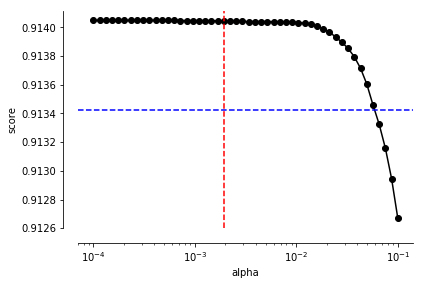

In [640]:
plt.plot(alphas, scores, '-ko')
plt.axhline(cv_score, color='b',ls='--')
plt.axvline(cv_alpha, color='r', ls='--')
plt.xlabel('alpha')
plt.ylabel('score')
#plt.xscale('linear')
plt.xscale('log')
sns.despine(offset=15)

In [641]:
predictions = lasso_cv.predict(X_test)

In [642]:
lasso_cv.score(x, y)

0.91342090244106677

In [643]:
print('MAE:', metrics.mean_absolute_error(y_test, predictions))
print('MSE:', metrics.mean_squared_error(y_test, predictions))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, predictions)))

MAE: 1.59238364106
MSE: 5.05318124464
RMSE: 2.24792821163


In [644]:
np.amax(scores)

0.91404866873850077

In [645]:
np.take(alphas, np.argmax(scores))

0.0001

Text(0,0.5,'predictions')

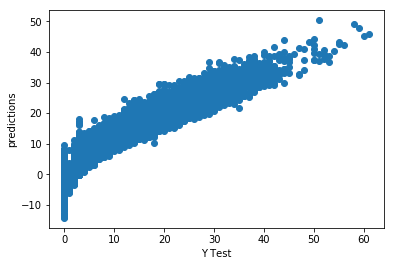

In [646]:
plt.scatter(y_test,predictions)
plt.xlabel('Y Test')
plt.ylabel('predictions')

1998 -- LCV 0.9147120588422647
1999 -- L 0.91471720437535364
2000 -- LCV 0.9147120588422647
2001 -- L 0.91486975706775964 ***
2002 -- LCV 0.91466119190003847
2003 -- LCV 0.91438136517439228
2004 -- L 0.91399705633731276
2005 -- LCV 0.91380910368478407
2006 -- LCV 0.91435034827094164
2007 -- L 0.9147827559782622
2008 -- 0.91404866873850077

In [647]:
test = """

select basic.player_id,
       play.name,
       bm.target as team,
       bm.game_hash,
       bm.game_date,
       basic.pts,
       basic.minutes_played,
       basic.fga,
       basic.3pa,
       basic.orb,
       basic.trb,
       basic.ast,
       basic.stl,
       basic.blk,
       basic.tov,
       basic.pf,
       adv.turnover_pct,
       adv.usage_pct,
       a_stats.pace,
       a_stats.pie,
       adv.offensive_rating,
       adv.defensive_rating,
       p_score.pct_2pt_fga,
       p_score.pct_3pt_fga, /*
       p_score.pct_pt_2pt,
       p_score.pct_pts_2pt_mr,
       p_score.pct_pts_3pt, */
       p_score.pct_pts_fbps,
       p_score.pct_pts_ft,
       p_score.pct_pts_off_to,
      -- p_usg.pct_fgm,
       p_usg.pct_fga,
      -- p_usg.pct_3pm,
       p_usg.pct_3pa,
      -- p_usg.pct_ftm,
       p_usg.pct_fta,
       p_usg.pct_stl,
       reg_avg.fg_a as tot_fg_a,
       reg_avg.3p_a as tot_3p_a,
       reg_avg.ft_a as tot_ft_a,
       reg_avg.reb as tot_reb,
       reg_avg.ast as tot_ast,
       reg_avg.blk as tot_blk,
       reg_avg.stl as tot_stl,
       reg_avg.pf as tot_pf,
       reg_avg.`TO` as tot_to,
       opp_team_pts.opp_pts,
       opp_team_pts.diff,
       misc.FBPS,
       misc.second_chance_pts

from (select gm.game_hash, gm.target, gm.opp, gm.game_date, gm.season, t.team_id as opp_id

      from (select m.game_hash, m.home_team as target, m.away_team as opp, m.game_date, lu.season
            from box_score_map as m
                   inner join game_date_lookup as lu on m.game_date = lu.day
            where m.home_team like 'Philadelphia%'

            union

            select m.game_hash, m.away_team as target, m.home_team as opp, m.game_date, lu.season
            from box_score_map as m
                   inner join game_date_lookup as lu on m.game_date = lu.day
            where m.away_team like 'Philadelphia%') as gm
             inner join team_info as t on gm.opp = t.team
      order by game_date desc
      limit 9) as bm
inner join team_info as t_opp on bm.opp = t_opp.team

inner join (

          select name, team, player_id
          from active_rosters
          where player_id not in (select player_id from injured_players) and
                team like 'Philadelphia%'

          ) as player on bm.target = player.team

inner join basic_box_stats as basic on ( (bm.game_hash = basic.game_hash) and (
player.player_id = basic.player_id) )
inner join advanced_box_stats as adv on ( (bm.game_hash = adv.game_hash) and (
player.player_id = adv.player_id) )
inner join player_scoring_stats as p_score on ( (bm.game_hash = p_score.game_hash) and (
player.player_id = p_score.player_id) )
inner join player_usage_stats as p_usg on ( (bm.game_hash = p_usg.game_hash) and (
player.player_id = p_usg.player_id) )
inner join team_advanced_boxscore_stats as a_stats on ( (bm.game_hash = a_stats.game_hash) and (bm.target = a_stats.team) )
left outer join RegularSeasonAverages as reg_avg on ( (basic.player_id = reg_avg.player_id) and (bm.season -1 = reg_avg.season) )
inner join points as opp_team_pts on bm.opp_id = opp_team_pts.team_id and bm.season -1 = opp_team_pts.season
inner join team_misc_boxscore_stats as misc on ( (bm.game_hash = misc.game_hash) and (bm.target = misc.team) )
inner join player_info as play on player.player_id = play.player_id
order by basic.player_id,
         bm.game_date asc;


"""

In [648]:
test_df = pd.read_sql(sql=test, con=conn)

In [649]:
test_df['minutes_played'] = test_df.loc[:, 'minutes_played'].apply(time_convert)
test_df = test_df.fillna(0).groupby(['player_id', 'name', 'team'], sort=False)
max_dates = test_df['game_date'].max().reset_index().loc[:, 'game_date'].apply(lambda x: (datetime.date.today() - x).days)
test = pd.concat([test_df.mean().reset_index(), max_dates], axis=1)

In [650]:
pred_df = test.loc[:, :'team']
predictions = lasso.predict(test.loc[:, 'minutes_played':])
predictions[predictions < 0] = 0
pred_df['pts'] = predictions
pred_df['game_date'] = datetime.date.today()
r_square = lasso.score(test.loc[:, 'minutes_played':], test['pts'])
total_pts = np.array([pred_df.iloc[0,2], str(datetime.date.today()), pred_df.iloc[:, -2].sum().astype(float), r_square]).reshape(1,4)
total_pts_df = pd.DataFrame(total_pts, index=None, columns=['team', 'game_date', 'predicted_total_pts', 'r_squared'])

In [651]:
r_square

0.96438363813198558

In [652]:
total_pts_df

,team,game_date,predicted_total_pts,r_squared
0,Philadelphia 76ers,2018-12-16,119.981245683,0.964383638132


In [653]:
pred_df

,player_id,name,team,pts,game_date
0,2490090,Mike Muscala,Philadelphia 76ers,8.454549,2018-12-16
1,2530531,T.J. McConnell,Philadelphia 76ers,9.123734,2018-12-16
2,3056484,Demetrius Jackson,Philadelphia 76ers,0.623431,2018-12-16
3,3056529,Joel Embiid,Philadelphia 76ers,23.276675,2018-12-16
4,3907388,Ben Simmons,Philadelphia 76ers,14.655335,2018-12-16
5,3929326,Furkan Korkmaz,Philadelphia 76ers,7.285996,2018-12-16
6,5352609,Amir Johnson,Philadelphia 76ers,1.108406,2018-12-16
7,5352864,JJ Redick,Philadelphia 76ers,19.013519,2018-12-16
8,5353034,Wilson Chandler,Philadelphia 76ers,8.135086,2018-12-16
9,5356270,Jimmy Butler,Philadelphia 76ers,19.740681,2018-12-16


In [533]:
### master query ###
####################
####################
####################

In [186]:
test = """
select basic.player_id,
       box_view.team,
       box_view.game_hash,
       box_view.game_date,
       basic.pts,
       basic.minutes_played,
       basic.fga,
       basic.3pa,
       basic.orb,
       basic.trb,
       basic.ast,
       basic.stl,
       basic.blk,
       basic.tov,
       basic.pf,
       adv.turnover_pct,
       adv.usage_pct,
       a_stats.pace,
       a_stats.pie,
       adv.offensive_rating,
      -- p_misc.pts_off_to,
      -- p_misc.second_chance_pts,
      -- p_misc.fbps as indv_fbps,
      -- p_misc.pitp,
       p_score.pct_2pt_fga,
       p_score.pct_3pt_fga, /*
       p_score.pct_pt_2pt,
       p_score.pct_pts_2pt_mr,
       p_score.pct_pts_3pt, */
       p_score.pct_pts_fbps,
       p_score.pct_pts_ft,
       p_score.pct_pts_off_to,
      -- p_usg.pct_fgm,
       p_usg.pct_fga,
      -- p_usg.pct_3pm,
       p_usg.pct_3pa,
      -- p_usg.pct_ftm,
       p_usg.pct_fta,
       p_usg.pct_stl, /*
       reg_avg.fg_a as tot_fg_a,
       reg_avg.3p_a as tot_3p_a,
       reg_avg.ft_a as tot_ft_a,
       reg_avg.reb as tot_reb,
       reg_avg.ast as tot_ast,
       reg_avg.blk as tot_blk,
       reg_avg.stl as tot_stl,
       reg_avg.pf as tot_pf,
       reg_avg.`TO` as tot_to, */
       opp_team_pts.opp_pts,
       opp_team_pts.diff,
       misc.FBPS,
       misc.second_chance_pts

from (

     select b.game_hash,
            b.home_team as team,
            b.game_date,
            team.team_id as away_id,
            lu.season
     from box_score_map as b
     inner join game_date_lookup as lu on b.game_date = lu.day
     inner join team_info as team on b.away_team = team.team
     where b.game_date < current_date and
           lu.season > 2006

     ) as box_view

inner join player_team_map as play_m on ( (box_view.team = play_m.team) and (
box_view.season = play_m.season) )
inner join basic_box_stats as basic on ( (box_view.game_hash = basic.game_hash) and (
play_m.player_id = basic.player_id) )
inner join advanced_box_stats as adv on ( (box_view.game_hash = adv.game_hash) and (
play_m.player_id = adv.player_id) )
-- inner join player_misc_stats as p_misc on ( (box_view.game_hash = p_misc.game_hash) and (
-- play_m.player_id = p_misc.player_id) )
inner join player_scoring_stats as p_score on ( (box_view.game_hash = p_score.game_hash) and (
play_m.player_id = p_score.player_id) )
inner join player_usage_stats as p_usg on ( (box_view.game_hash = p_usg.game_hash) and (
play_m.player_id = p_usg.player_id) )
inner join team_advanced_boxscore_stats as a_stats on ( (box_view.game_hash = a_stats.game_hash) and (box_view.team = a_stats.team) )
-- left outer join RegularSeasonAverages as reg_avg on ( (basic.player_id = reg_avg.player_id) and (box_view.season -1 = reg_avg.season) )
inner join points as opp_team_pts on box_view.away_id = opp_team_pts.team_id and box_view.season -1 = opp_team_pts.season
inner join team_misc_boxscore_stats as misc on ( (box_view.game_hash = misc.game_hash) and (box_view.team = misc.team) )
order by basic.player_id,
         box_view.game_date asc;"""